In [1]:
%%time

import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KDTree

CPU times: user 3.05 s, sys: 63.5 ms, total: 3.12 s
Wall time: 802 ms


In [2]:
region_id = 69300

tessellations_dir = '/data/uscuni-ulce/processed_data/tessellations/'
chars_dir = "/data/uscuni-ulce/processed_data/chars/"
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"
val_path = '../data/prague_validation/morphotopes.pq'

In [3]:
region_id = 'freiburg'
buildings_dir = streets_dir = enclosures_dir = tessellations_dir = graph_dir = '../data/freiburg/'
chars_dir = '../data/freiburg/chars/'
val_path = '../data/fbg_cluster_validation.pq'

In [4]:
# gpd.read_parquet('../data/fbg_cluster_validation.pq').explore()

In [5]:
graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")

In [6]:
graph.cardinalities.describe()

count    36183.000000
mean         6.885913
std          2.030835
min          1.000000
25%          6.000000
50%          7.000000
75%          8.000000
max         69.000000
Name: cardinalities, dtype: float64

In [7]:
from core.cluster_validation import print_distance, generate_neigbhourhood_groups, generate_detailed_clusters

In [8]:
tessellation = gpd.read_parquet(
        tessellations_dir + f"tessellation_{region_id}.parquet"
)

In [15]:
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')



X_train = X_train[X_train.index >= 0]



# spatial_lag = 3

# # lag = pd.read_parquet(f'/data/uscuni-ulce/processed_data/context_data/context_chars_{region_id}_lag_{spatial_lag}.parquet')

# lag = pd.read_parquet(f'/data/uscuni-ulce/processed_data/context_data/unprocessed_context_chars_{region_id}_lag_{spatial_lag}_sw.parquet')


# X_train = X_train.join(lag[[c for c in lag.columns if '_median' in c]], how='inner')

# X_train = X_train.join(lag, how='inner')


In [16]:
# for c in X_train.columns:
#     X_train[c] = X_train[c].clip(*np.percentile(X_train[c], [5, 95]))

In [17]:
to_drop = [
    'stcSAl',
 # 'ltkOri',
 # 'stbOri',
 'stcOri',
 # 'stbCeA',

#not in barcelona
 # 'ltcBuA', 'midRea', 'midAre', 'likWBB'
]


all_drop = []
for c in to_drop:
    all_drop += X_train.columns[X_train.columns.str.contains(c)].tolist()


X_train = X_train.drop(all_drop, axis=1)

In [18]:

# vals = StandardScaler().fit_transform(X_train)
# X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)

# vals = np.nan_to_num(X_train)
# X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)

In [19]:
# t1 = X_train[[c for c in X_train.columns if '_' not in c]]
# X_train = X_train[[c for c in X_train.columns if '_median' in c]]

# X_train = t1.join(t2)
# X_train.shape

In [20]:
# X_train = X_train.drop(stats.columns[stats.loc['std'] == 0], axis=1)

In [21]:
X_train.shape

(36067, 62)

In [22]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score
from core.cluster_validation import get_linkage_matrix

In [23]:
q1 = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")

# clustering_graph = q1.higher_order(k=3, lower_order=True, diagonal=True).subgraph(X_train.index.values)

clustering_graph = q1.copy()

In [24]:
graph_labels = q1.subgraph(X_train.index.values).component_labels
graph_labels.value_counts()

component labels
3     34505
4       771
21      614
23       79
9        18
7        17
24       16
6         8
22        7
19        5
8         4
25        3
26        2
5         2
28        2
18        1
27        1
20        1
0         1
17        1
16        1
15        1
1         1
13        1
12        1
11        1
10        1
2         1
14        1
Name: count, dtype: int64

In [25]:
clustering_graph = clustering_graph.subgraph(graph_labels[graph_labels == 3].index.values)
core_ids = clustering_graph.unique_ids

In [26]:
# clustering_graph = q1.subgraph(q1.component_labels[q1.component_labels == 25].index.values)
# clustering_graph = clustering_graph.subgraph(clustering_graph.unique_ids[clustering_graph.unique_ids >= 0])
# core_ids = clustering_graph.unique_ids

In [27]:
training_data = X_train[X_train.index.isin(core_ids)]

In [28]:


# training_data = training_data[[c for c in training_data.columns if '_' not in c]]


In [29]:
# t1 = training_data[[c for c in training_data.columns if '_' not in c]]
# t2 = training_data[[c for c in training_data.columns if '_median' in c]]

# training_data = t1.join(t2)

In [30]:
# training_data = X_train[X_train.index >=0]
# clustering_graph = graph.subgraph(X_train.index)

In [31]:
training_data.shape

(34505, 62)

In [32]:
vals = StandardScaler().fit_transform(training_data)
training_data = pd.DataFrame(vals, columns=training_data.columns, index=training_data.index)

vals = np.nan_to_num(training_data)
training_data = pd.DataFrame(vals, columns=training_data.columns, index=training_data.index)

stats = training_data.describe()
training_data = training_data.drop(stats.columns[stats.loc['std'] == 0], axis=1)

In [81]:
training_data = training_data.clip(-10, 10)

In [102]:
%%time
clusterer = AgglomerativeClustering(
    linkage='ward',
    # metric='cityblock',
                                                  
    connectivity = clustering_graph.transform('B').sparse, 
    
                                    # connectivity=q1.subgraph(X_train.index.values).transform('B').sparse, 
                                    compute_full_tree=True,
                                    compute_distances=True)
model = clusterer.fit(training_data)

CPU times: user 840 ms, sys: 17.1 ms, total: 858 ms
Wall time: 857 ms


In [103]:
linkage_matrix = get_linkage_matrix(model)

In [104]:
# fix, ax = plt.subplots(figsize=(40,40))
# # Plot the corresponding dendrogram
# _ = dendrogram(linkage_matrix, truncate_mode="level", p=5, ax=ax)

In [105]:
from sklearn.metrics import calinski_harabasz_score

In [106]:
tess_groups = generate_detailed_clusters(tessellation,
                                         include_random_sample=False, path=val_path)
tess_groups = tess_groups[tess_groups.index.isin(training_data.index)]
tess_groups_ilocs = (
    pd.Series(np.arange(len(training_data)), index=training_data.index)
    .loc[tess_groups.index]
    .values
)

In [107]:
first = linkage_matrix[0, 2]
last = linkage_matrix[-1, 2]
step = ((last / 2) - first) / 25

In [108]:
res = []
i = 0
for i in range(0, 25):

    t = first + step *  (i + 1)
    if t >= linkage_matrix[-1, 2]:
        break
    
    r = fcluster(linkage_matrix, t=t, criterion='distance')
    r = pd.Series(r, index=training_data.index)
    ssplits = clustering_graph.describe(r, statistics=['nunique'])['nunique']

    res.append((t,
          adjusted_rand_score(tess_groups.values, r.iloc[tess_groups_ilocs]),
          (ssplits > 1).sum() / ssplits.shape[0],
          davies_bouldin_score(training_data, r),
          calinski_harabasz_score(training_data, r)
         ))
pd.DataFrame(res, columns = ['cutoff', 'rand', 'ssplits', 'db_score', 'ch_score']).set_index('cutoff')

,rand,ssplits,db_score,ch_score
cutoff,,,,
8.153495,0.019969,0.951775,1.338386,30.695407
16.288317,0.069819,0.765512,1.972226,54.799671
24.423138,0.145100,0.615186,2.385903,82.801149
32.557960,0.212995,0.500275,2.645692,113.474045
40.692782,0.299796,0.427011,2.830440,146.559833
48.827603,0.413360,0.378496,2.970606,177.881389
56.962425,0.513048,0.334183,3.181935,219.298974
65.097246,0.537052,0.298507,3.354519,262.941083
73.232068,0.565169,0.278394,3.492895,297.189184


In [109]:
# res = []
# for t in range(5, 25, 1):

#     if t >= linkage_matrix[-1, 2]:
#         break
    
#     r = fcluster(linkage_matrix, t=t, criterion='distance')
#     r = pd.Series(r, index=training_data.index)
#     ssplits = clustering_graph.describe(r, statistics=['nunique'])['nunique']

#     res.append((t,
#           adjusted_rand_score(tess_groups.values, r.iloc[tess_groups_ilocs]),
#           (ssplits > 1).sum() / ssplits.shape[0],
#           davies_bouldin_score(training_data, r),
#           calinski_harabasz_score(training_data, r)
#          ))
# pd.DataFrame(res, columns = ['cutoff', 'rand', 'ssplits', 'db_score', 'ch_score']).set_index('cutoff')

In [110]:
# try hdbscan extraction
from fast_hdbscan.boruvka import parallel_boruvka
from fast_hdbscan.cluster_trees import (
    cluster_tree_from_condensed_tree,
    condense_tree,
    extract_eom_clusters,
    get_cluster_label_vector,
    mst_to_linkage_tree,
)
from fast_hdbscan.numba_kdtree import kdtree_to_numba
from sklearn.neighbors import KDTree

In [111]:
res = []

for min_cluster_size in range(25, 500, 25):


    condensed_tree = condense_tree(linkage_matrix, 
                                   min_cluster_size=min_cluster_size)
    cluster_tree = cluster_tree_from_condensed_tree(condensed_tree)
    selected_clusters = extract_eom_clusters(
        condensed_tree, cluster_tree, allow_single_cluster=False
    )
    r = get_cluster_label_vector(condensed_tree, selected_clusters, 0)


    r = pd.Series(r, index=training_data.index)
    ssplits = clustering_graph.describe(r, statistics=['nunique'])['nunique']

    res.append((min_cluster_size,
          adjusted_rand_score(tess_groups.values, r.iloc[tess_groups_ilocs]),
          (ssplits > 1).sum() / ssplits.shape[0],
          davies_bouldin_score(training_data, r),
          calinski_harabasz_score(training_data, r)
         ))

pd.DataFrame(res, columns = ['min__cluster_size', 'rand', 'ssplits', 'db_score', 'ch_score']).set_index('min__cluster_size')

,rand,ssplits,db_score,ch_score
min__cluster_size,,,,
25,0.129554,0.658165,2.834380,69.415176
50,0.238317,0.511578,3.182541,110.865773
75,0.315580,0.447703,3.357650,133.946125
100,0.361112,0.397276,3.501560,166.304860
125,0.384988,0.360614,3.664281,193.611601
150,0.443821,0.340849,3.769582,222.575212
175,0.503211,0.289175,3.881956,261.692665
200,0.500085,0.283292,3.926636,272.159069
225,0.498529,0.269410,4.029063,285.627994


In [112]:
condensed_tree = condense_tree(linkage_matrix, 
                               min_cluster_size=275)
cluster_tree = cluster_tree_from_condensed_tree(condensed_tree)
selected_clusters = extract_eom_clusters(
    condensed_tree, cluster_tree, allow_single_cluster=False
)
clusters = get_cluster_label_vector(condensed_tree, selected_clusters, 0)

In [113]:
plotting = tessellation.loc[training_data.index].reset_index()

In [94]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(plotting, opacity=.08)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 558 ms, sys: 42.4 ms, total: 600 ms
Wall time: 599 ms


In [95]:
from sidecar import Sidecar
sc = Sidecar(title='Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

In [96]:
from core.cluster_validation import get_color

In [114]:
clusters = fcluster(linkage_matrix, t=130, criterion='distance')

In [116]:


condensed_tree = condense_tree(linkage_matrix, 
                               min_cluster_size=100)
cluster_tree = cluster_tree_from_condensed_tree(condensed_tree)
selected_clusters = extract_eom_clusters(
    condensed_tree, cluster_tree, allow_single_cluster=False
)
clusters = get_cluster_label_vector(condensed_tree, selected_clusters, 0)

In [117]:
# np.unique(clusters, return_counts=True)

In [118]:
layer.get_fill_color = get_color(clusters)

In [57]:
from scipy.cluster.hierarchy import inconsistent

In [58]:
%%time
inc = inconsistent(linkage_matrix, d=10)

CPU times: user 141 ms, sys: 12 μs, total: 141 ms
Wall time: 141 ms


In [70]:
np.where(inc[:, 3] > 5)

(array([154210, 154515, 155511, ..., 166753, 166754, 166755]),)

----

In [46]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [47]:
# component_data = X_train.loc[labels.groupby(labels).get_group(label).index.values]

component_data = X_train.loc[region_cluster_labels.index]

NameError: name 'region_cluster_labels' is not defined

In [81]:
# component_data = component_data.groupby(results[label]).agg([np.min, np.median, np.max])

In [82]:
# component_data = component_data.groupby(results[label]).agg([percentile(10), 
#                                                              'median', 
#                                                              percentile(90)])

In [83]:
%%time
component_data = component_data.groupby(region_cluster_labels.values).agg([percentile(10), 
                                                             'median', 
                                                             percentile(90)])

CPU times: user 1.36 s, sys: 0 ns, total: 1.36 s
Wall time: 1.35 s


In [84]:
component_data

sdbAre                                  sdbPer             \
       percentile_10      median percentile_90 percentile_10     median   
0_1.0     158.469588  158.469588    158.469588     51.195015  51.195015   
10_1.0     24.995869   24.995869     24.995869     20.325831  20.325831   
11_1.0      6.378458    6.378458      6.378458     10.146418  10.146418   
12_1.0    117.428260  117.428260    117.428260     44.472631  44.472631   
13_1.0    134.018525  134.018525    134.018525     56.066456  56.066456   
...              ...         ...           ...           ...        ...   
5_1.0      71.601454  127.778758    183.956061     36.044147  51.116402   
6_1.0      16.593783   22.347574    104.627653     17.377131  19.745407   
7_1.0      18.271826  166.434128    565.836413     17.577434  52.009857   
8_1.0      55.468548   66.930641    155.223430     31.041228  40.410358   
9_1.0      14.158693   92.076144   2532.373037     15.417828  40.555035   

                            sdbCoA                             ssbCCo  ...  \
       percentile_90 percentile_10 median percentile_90 percentile_10  ...   
0_1.0      51.195015           0.0    0.0           0.0      0.595764  ...   
10_1.0     20.325831           0.0    0.0           0.0      0.595020  ...   
11_1.0     10.146418           0.0    0.0           0.0      0.624573  ...   
12_1.0     44.472631           0.0    0.0           0.0      0.643355  ...   
13_1.0     56.066456           0.0    0.0           0.0      0.392704  ...   
...              ...           ...    ...           ...           ...  ...   
5_1.0      66.188657           0.0    0.0           0.0      0.429574  ...   
6_1.0      39.857137           0.0    0.0           0.0      0.437883  ...   
7_1.0     125.681820           0.0    0.0           0.0      0.291255  ...   
8_1.0      52.342059           0.0    0.0           0.0      0.293687  ...   
9_1.0     344.754346           0.0    0.0           0.0      0.237455  ...   

              ltkWNB        likWBB                                 sdsAre  \
       percentile_90 percentile_10    median percentile_90  percentile_10   
0_1.0       0.003107      0.006032  0.006032      0.006032  131150.244631   
10_1.0      0.001542      0.000748  0.000748      0.000748  110517.333155   
11_1.0      0.001567      0.000197  0.000197      0.000197   72872.139955   
12_1.0      0.005650      0.006385  0.006385      0.006385   35802.256088   
13_1.0      0.003085      0.004432  0.004432      0.004432  110936.743070   
...              ...           ...       ...           ...            ...   
5_1.0       0.009315      0.007682  0.009550      0.011418  123988.920003   
6_1.0       0.001357      0.009704  0.009704      0.009704   27294.158889   
7_1.0       0.001766      0.028962  0.041850      0.041850  216162.254352   
8_1.0       0.001209      0.007972  0.007972      0.007972  216162.254352   
9_1.0       0.001464      0.165478  0.165478      0.165478   96713.265454   

                                            likWCe                          
               median  percentile_90 percentile_10    median percentile_90  
0_1.0   131150.244631  131150.244631      0.000038  0.000038      0.000038  
10_1.0  110517.333155  110517.333155      0.000030  0.000030      0.000030  
11_1.0   72872.139955   72872.139955      0.000031  0.000031      0.000031  
12_1.0   35802.256088   35802.256088      0.000054  0.000054      0.000054  
13_1.0  110936.743070  110936.743070      0.000033  0.000033      0.000033  
...               ...            ...           ...       ...           ...  
5_1.0   123988.920003  123988.920003      0.000067  0.000093      0.000119  
6_1.0    29342.595346   29342.595346      0.000187  0.000187      0.000187  
7_1.0   216162.254352  216162.254352      0.000114  0.000144      0.000144  
8_1.0   216162.254352  216162.254352      0.000084  0.000084      0.000084  
9_1.0    96713.265454   96713.265454      0.000191  0.000191      0.000191  

[215 rows x 189 col

In [85]:
vals = StandardScaler().fit_transform(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)

# component_data = component_data[component_data.index >= 0]
vals = np.nan_to_num(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)

In [86]:
import umap
import umap.plot

reducer = umap.UMAP(n_neighbors=15, n_components=15, min_dist=0, metric='euclidean', verbose=True)
# reducer = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0, metric='cosine', verbose=True)
embedding = reducer.fit_transform(component_data)
# umap.plot.points(reducer)

UMAP(min_dist=0, n_components=15, verbose=True)
Mon Aug 26 16:13:54 2024 Construct fuzzy simplicial set
Mon Aug 26 16:13:54 2024 Finding Nearest Neighbors
Mon Aug 26 16:13:54 2024 Finished Nearest Neighbor Search
Mon Aug 26 16:13:54 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Aug 26 16:13:55 2024 Finished embedding


In [87]:
clusterer = AgglomerativeClustering(linkage='complete',
                                    compute_full_tree=True,
                                    compute_distances=True)
model = clusterer.fit(embedding)
linkage_matrix = get_linkage_matrix(model)

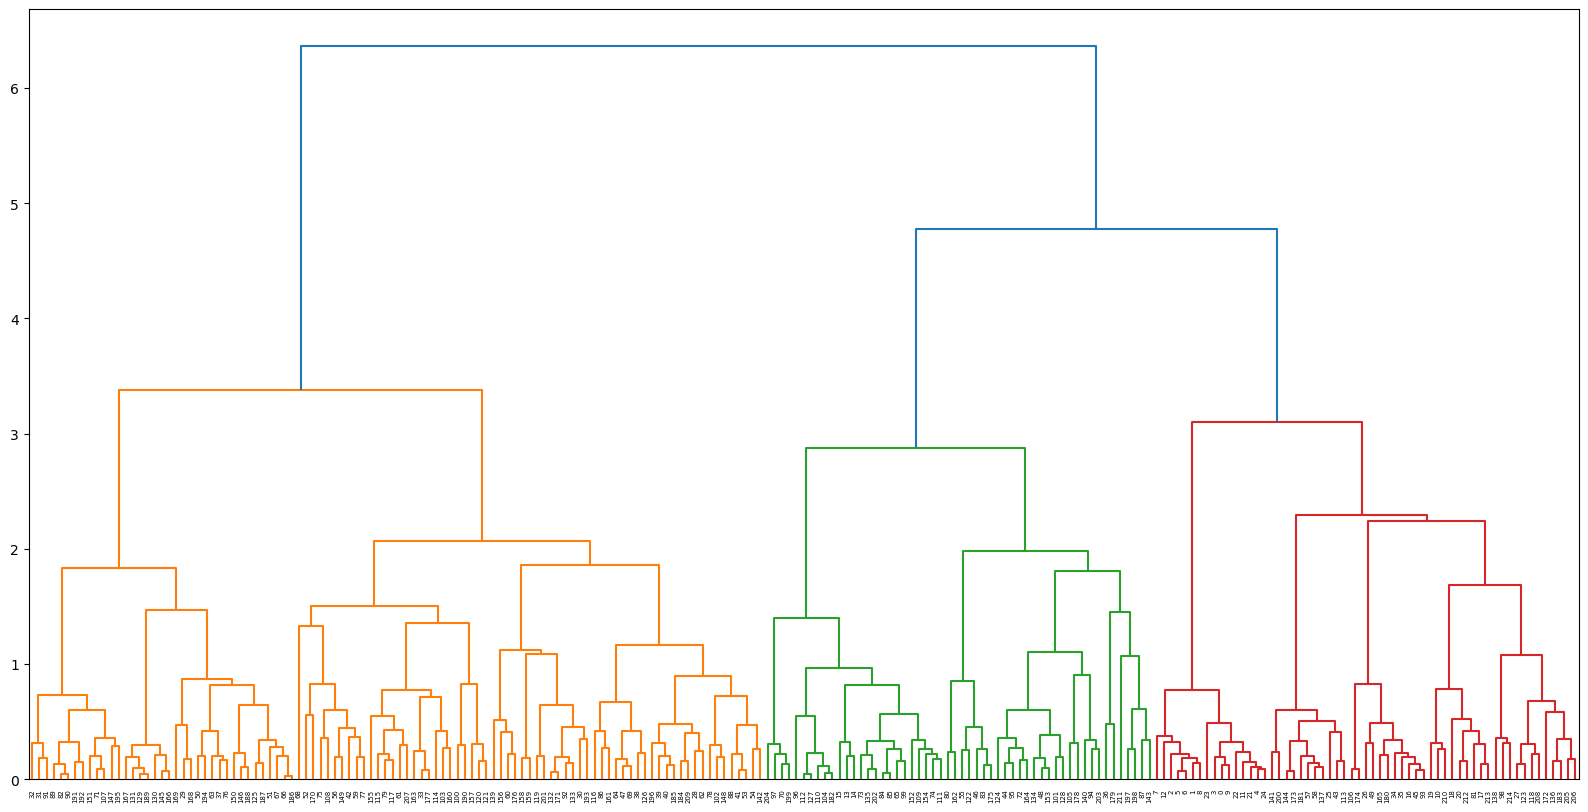

In [88]:
fig,ax = plt.subplots(figsize=(20,10))
_ = dendrogram(linkage_matrix, ax=ax)

In [56]:
clusters = fcluster(linkage_matrix, t=2, criterion='distance')

In [57]:
# from sklearn.cluster import KMeans, MiniBatchKMeans
# from sklearn.metrics import adjusted_rand_score
# clusters = KMeans(n_clusters=25, max_iter=5000, n_init=300).fit(embedding).labels_

In [58]:
# morh_clusters = results[label]
morh_clusters = region_cluster_labels.values

In [59]:
clusters = pd.Series(clusters, index=component_data.index.values)
clusters = clusters.loc[morh_clusters].values

In [60]:
# assert clusters.shape == results[label].shape

# for i in np.unique(results[label]):
#     idxs = np.where(results[label] == i)[0]
#     old_clusters = results[label][idxs]
#     new_clusters = clusters[idxs]
#     assert np.unique(old_clusters).shape[0] == 1
#     assert np.unique(new_clusters).shape[0] == 1
    

In [61]:
np.unique(clusters, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([7439, 6149, 3450, 3874,   18, 2750,  687, 4019, 7681]))

In [53]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(tessellation[tessellation.index >= 0], opacity=.08)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 597 ms, sys: 40.1 ms, total: 637 ms
Wall time: 637 ms


In [54]:
from sidecar import Sidecar
sc = Sidecar(title='Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

In [62]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(clusters)